CT204/109433/22:
SHELDON VWINAH KENYANI

In [1]:
!pip install yfinance
!pip install yahoofinancials
!pip install --upgrade numpy
!pip install --upgrade pmdarima

In [2]:
!pip install statsmodels
!pip install yfinance statsmodels arch matplotlib pandas scikit-learn
!pip install yfinance pmdarima

In [ ]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [4]:
data = yf.download('META',
                      start='2022-04-25',
                      end='2025-04-25')
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2022-04-25,186.112869,186.301965,180.807870,181.872842,29281100
2022-04-26,180.101181,186.311915,178.657986,185.754545,31747400
2022-04-27,174.129349,180.359994,168.207262,173.611784,71062900
2022-04-28,204.764954,207.551822,191.995135,201.968137,100890600
2022-04-29,199.529602,211.483258,198.962269,203.500891,49193400


In [5]:
import yfinance as yf
from yahoofinancials import YahooFinancials

data = yf.download('META',
                      start='2022-04-25',
                      end='2025-04-25')
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2025-04-17,501.480011,507.299988,498.010010,505.250000,14593500
2025-04-21,484.660004,493.500000,479.799988,491.329987,16166000
2025-04-22,500.279999,506.880005,486.359985,491.869995,17399400
2025-04-23,520.270020,535.340027,516.520020,528.530029,18173900
2025-04-24,533.150024,533.900024,517.500000,518.729980,13910000


Data Pre-processing

Dataset was clean ie there were no missing values or duplicates

In [6]:
#checking for missing values
data.isnull().sum()

,,0
Price,Ticker,
Close,META,0
High,META,0
Low,META,0
Open,META,0
Volume,META,0


In [7]:
#duplicate checking
data.duplicated().sum()

np.int64(0)

Close price time plot

<ipython-input-8-9dd4740689a9>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


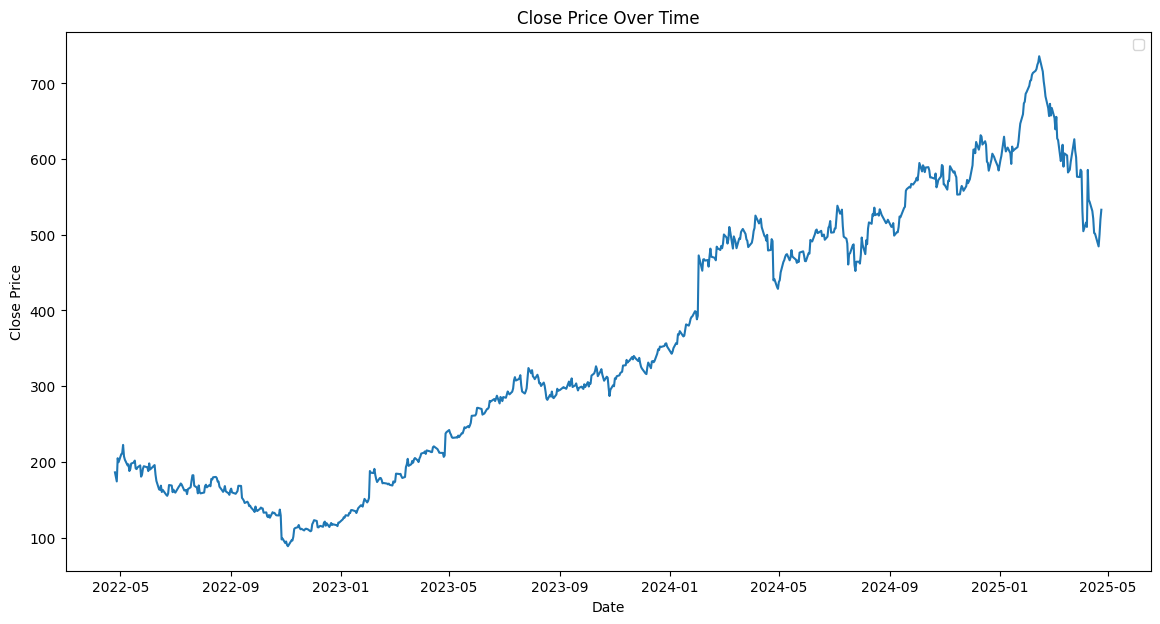

In [8]:
# Plotting the Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Close"])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Check for stationarity; perform ADF test to check stationarity of the series.Most stock prices are non stationary therefore we make them stationary by differencing

In [9]:
#Check for stationarity and perform differencing if series is non stationary
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): -0.6844
p-value (Original): 0.8508
Interpretation: The original series is Non-Stationary.



The original series is Non-Stationary therefore we make the series stationary by differencing

In [10]:
# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()
# Drop the first row containing the NaN value
#data = data.dropna()

In [11]:
result_diff = adfuller(data['Close_Diff'].dropna())

print(f"ADF Statistic (Original): {result_diff[0]:.4f}")
print(f"p-value (Original): {result_diff[1]:.4f}")

if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.\n")
else:
    print("Interpretation: The differenced series is Non-Stationary.\n")

ADF Statistic (Original): -29.0368
p-value (Original): 0.0000
Interpretation: The differenced series is Stationary.



Differenced series Close price time plot

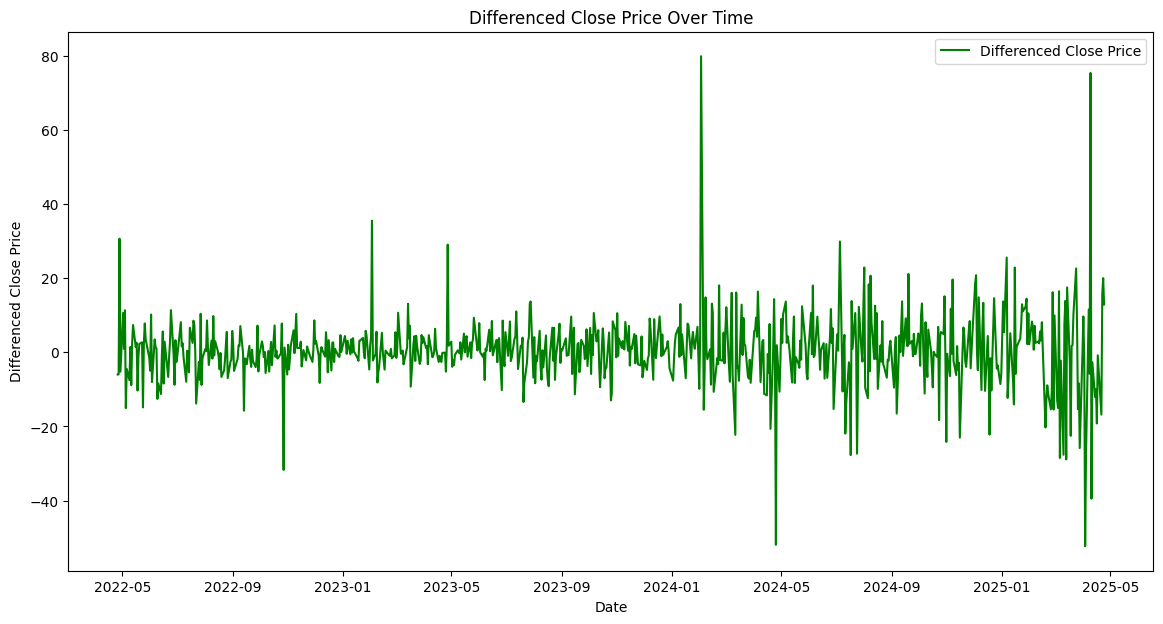

In [12]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_Diff'], label='Differenced Close Price', color='green')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

Model identification


using ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) to obtain values of p,d and q

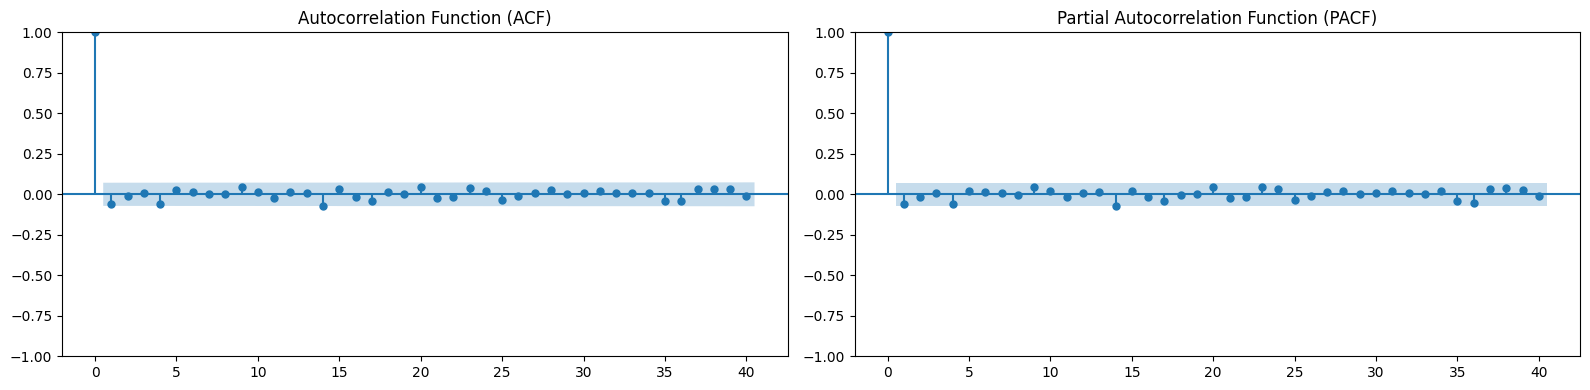

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close_Diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -29.03678002856681
p-value: 0.0


If the p-value > 0.05, the series is non-stationary → set d = 1
If p-value < 0.05, it's already stationary → set d = 0
order = (1, 1, 1)  # (p, d, q)


split data into training and testing (90% for training and 10% testing )

In [15]:
train_size = int(len(data['Close']) * 0.9)
train_data = data[:train_size]
test_data = data[train_size:]

Fit ARIMA Model

In [16]:
# Fit ARIMA model on order 1,1,1 as established
model = ARIMA(train_data["Close"], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   META   No. Observations:                  677
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2374.372
Date:                Thu, 15 May 2025   AIC                           4754.744
Time:                        15:26:07   BIC                           4768.293
Sample:                             0   HQIC                          4759.990
                                - 677                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4053      0.533      0.760      0.447      -0.639       1.450
ma.L1         -0.4606      0.517     -0.892      0.373      -1.473       0.552
sigma2        65.8136      1.165     56.495      0.0

Model forecasting and plot forecast  results

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


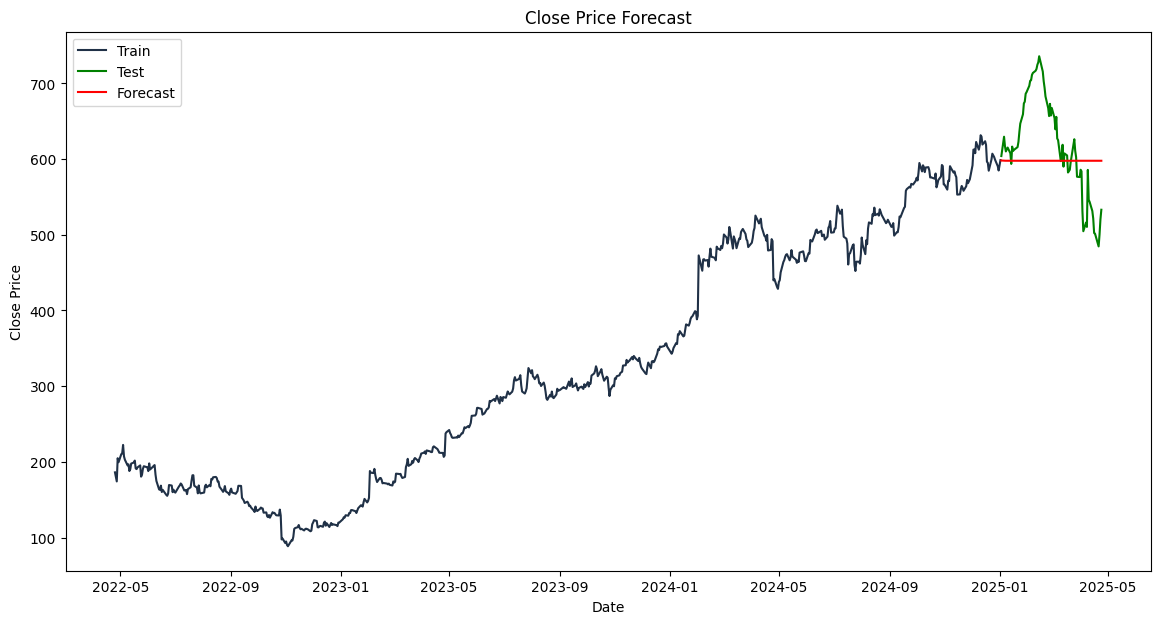

In [17]:
# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data["Close"], label='Train', color='#203147')
plt.plot(test_data.index, test_data["Close"], label='Test', color='green')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [18]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 4754.743938009049
BIC: 4768.292517237178


model evaluation

In [19]:
import numpy as np
forecast = forecast[:len(test_data)]
test_close = test_data["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 67.9462


RMSE of 67.9462 will indicate the difference in the actual and predicted values

getting the values for the next days i.e after close date picked (2025-04-25) that have been forecasted

In [20]:
# Specify the future dates for forecasting
future_dates = pd.date_range(start='2025-04-20', periods=10)  #forecast for the next 10 days

# Forecast the future values
forecast_future = model_fit.forecast(steps=len(future_dates))

# Create a DataFrame to store the forecast
future_forecast_df = pd.DataFrame({'Date': future_dates, 'Close_Forecast': forecast_future})
future_forecast_df = future_forecast_df.set_index('Date')


# Display or use the future forecasts
print(future_forecast_df)

            Close_Forecast
Date                      
2025-04-20      598.212334
2025-04-21      598.011702
2025-04-22      597.930383
2025-04-23      597.897424
2025-04-24      597.884065
2025-04-25      597.878650
2025-04-26      597.876456
2025-04-27      597.875566
2025-04-28      597.875205
2025-04-29      597.875059


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
data = yf.download('META',
                      start='2024-04-18',
                      end='2025-04-27')
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2025-04-21,484.660004,493.500000,479.799988,491.329987,16166000
2025-04-22,500.279999,506.880005,486.359985,491.869995,17399400
2025-04-23,520.270020,535.340027,516.520020,528.530029,18173900
2025-04-24,533.150024,533.900024,517.500000,518.729980,13910000
2025-04-25,547.270020,549.859985,536.250000,546.799988,17098900


ARCH and GARCH Model

In [22]:
from arch import arch_model

calculate returns

In [23]:
returns = data['Close'].pct_change().dropna() * 100

Plot Returns

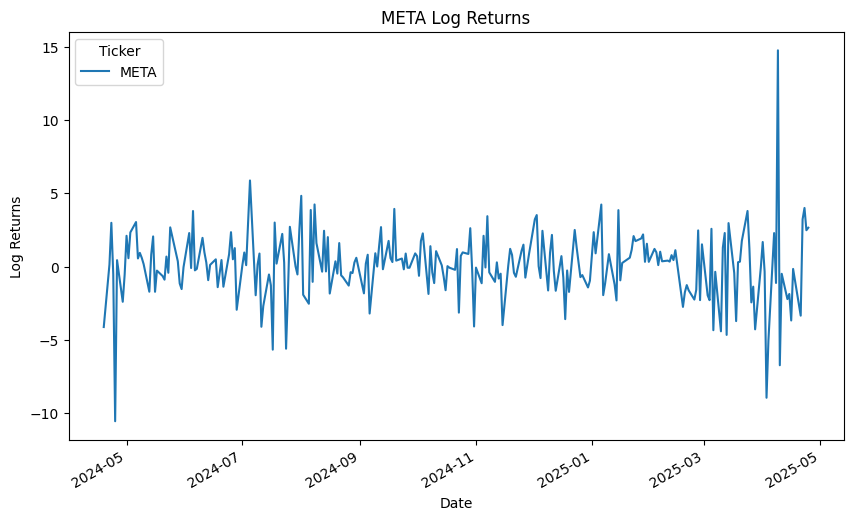

In [24]:
returns.plot(title='META Log Returns', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

split returns into training and testing

In [25]:
# 2. Split returns
# Split data into training and testing sets
train_size = int(len(returns) * 0.9)
train_returns = returns[:train_size]
test_returns = returns[train_size:]


In [26]:
print(f"Train size:{train_returns.shape}")
print(f"Test size:{test_returns.shape}")

Train size:(229, 1)
Test size:(26, 1)


Fit ARCH model using p,lag for autoregression

In [27]:
# 3. Fit ARCH(1) model
model_arch = arch_model(train_returns, vol='ARCH', p=1)
fit_arch = model_arch.fit(disp='off')
arch_forecast = fit_arch.forecast(horizon=30)
arch_vol = arch_forecast.variance.values[-1, :]

Fit GARCH model using p,lag for autoregression and q,for moving average

In [28]:
# 4. Fit GARCH(1,1) model
model_garch = arch_model(train_returns, vol='GARCH', p=1, q=1)
fit_garch = model_garch.fit(disp='off')
garch_forecast = fit_garch.forecast(horizon=30)
garch_vol = garch_forecast.variance.values[-1, :]

Plot volatility forecasts to compare the models

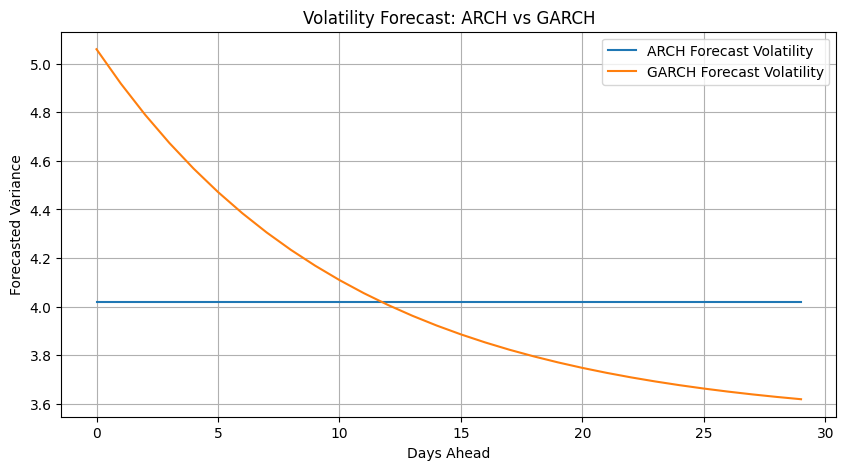

In [29]:
# 5. Plotting the volatility forecasts
plt.figure(figsize=(10, 5))
plt.plot(arch_vol, label='ARCH Forecast Volatility')
plt.plot(garch_vol, label='GARCH Forecast Volatility')
plt.title('Volatility Forecast: ARCH vs GARCH')
plt.xlabel('Days Ahead')
plt.ylabel('Forecasted Variance')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Forecast volatility (e.g., 10 days ahead)
forecast = fit_garch.forecast(horizon=10)
vol_forecast = np.sqrt(forecast.variance.values[-1, :])
print("10-day Volatility Forecast:", vol_forecast)

10-day Volatility Forecast: [2.24936897 2.21773779 2.18862462 2.16185386 2.13725885 2.11468184
 2.09397382 2.07499448 2.05761192 2.04170249]


In [31]:
print("ARCH AIC:", fit_arch.aic)
print("GARCH AIC:", fit_garch.aic)

ARCH AIC: 974.3457598539335
GARCH AIC: 960.635686249024


In [32]:
print("ARCH BIC:", fit_arch.bic)
print("GARCH BIC:", fit_garch.bic)

ARCH BIC: 984.6469258645963
GARCH BIC: 974.370574263241


Lower AIC and BIC indicate better model,therefore GARCH seems to be better

GARCH outer performs ARCH. GARCH models react to shock and smooth variance changes overtime